In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [21]:
df = pd.read_csv('data.csv')

In [22]:
base_features = [
    'age',
    'bmi',
    'female',
    'typical',
    'max',
    'sprint',
    'tempo',
    'injury'
]

race_cols = {
    'k5': ('k5_ti', 'k5_di', 'k5_tr'),
    'k10': ('k10_ti', 'k10_di', 'k10_tr'),
    'm5': ('m5_ti', 'm5_di', 'm5_tr'),
    'm10': ('m10_ti', 'm10_di', 'm10_tr'),
    'mh': ('mh_ti', 'mh_di', 'mh_tr'),
    'mf': ('mf_ti', 'mf_di', 'mf_tr')
}

# Create indicator variables for each race
for prefix, (time, _, _) in race_cols.items():
    df[f'{prefix}_ind'] = df[time].notnull().astype(int)

target = 'k10_ti'
df = df[pd.notnull(df[target])]

In [23]:
k10_features = ['k10_di', 'k10_tr']
k5_features = ['k5_ind', 'k5_ti', 'k5_di', 'k5_tr']
mh_features = ['mh_ind', 'mh_ti', 'mh_di', 'mh_tr']
mf_features = ['mf_ind', 'mf_ti', 'mf_di', 'mf_tr']

base_features.extend(k10_features)
base_features.extend(k5_features)
base_features.extend(mh_features)
base_features.extend(mf_features)

In [24]:
print("\nDataset Summary:")
print(f"Total number of runners: {len(df)}")
print("\nRace completion rates:")
for prefix, (time_col, _, _) in race_cols.items():
    completion_rate = (df[f'{prefix}_ind'] == 1).mean() * 100
    print(f"{prefix}: {completion_rate:.1f}%")



Dataset Summary:
Total number of runners: 946

Race completion rates:
k5: 52.9%
k10: 100.0%
m5: 7.3%
m10: 9.9%
mh: 55.9%
mf: 30.5%


In [25]:
from sklearn.model_selection import cross_val_score


X = df[base_features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize model
# Note: XGBoost handles missing values internally
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    # Enable built-in missing value handling
    missing=np.nan,
    eval_metric=['rmse'],
)

# Perform cross-validation
cv_scores = cross_val_score(
    model, X_train, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

print("\nCross-validation RMSE scores:")
print(f"Mean: {-cv_scores.mean():.2f} seconds")
print(f"Std: {cv_scores.std():.2f} seconds")


Cross-validation RMSE scores:
Mean: 343.78 seconds
Std: 30.03 seconds


In [26]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:674.78308	validation_1-rmse:604.96002
[1]	validation_0-rmse:652.04150	validation_1-rmse:586.62505
[2]	validation_0-rmse:630.82496	validation_1-rmse:568.12011
[3]	validation_0-rmse:613.03388	validation_1-rmse:551.69108
[4]	validation_0-rmse:596.43627	validation_1-rmse:537.53372
[5]	validation_0-rmse:578.04873	validation_1-rmse:520.72449
[6]	validation_0-rmse:561.38044	validation_1-rmse:506.54545
[7]	validation_0-rmse:544.30542	validation_1-rmse:492.61429
[8]	validation_0-rmse:531.17226	validation_1-rmse:482.26676
[9]	validation_0-rmse:519.19121	validation_1-rmse:471.85393
[10]	validation_0-rmse:505.07897	validation_1-rmse:459.80058
[11]	validation_0-rmse:492.47170	validation_1-rmse:449.11939
[12]	validation_0-rmse:479.39705	validation_1-rmse:437.45996
[13]	validation_0-rmse:467.73007	validation_1-rmse:427.44981
[14]	validation_0-rmse:458.28429	validation_1-rmse:418.73970
[15]	validation_0-rmse:448.95030	validation_1-rmse:411.01194
[16]	validation_0-rmse:439.33320	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse'], feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [27]:
# Make predictions
test_preds = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, test_preds))
mae = mean_absolute_error(y_test, test_preds)

print(f"\nTest Set Metrics:")
print(f"RMSE: {rmse:.2f} seconds ({rmse/60:.2f} minutes)")
print(f"MAE: {mae:.2f} seconds ({mae/60:.2f} minutes)")


Test Set Metrics:
RMSE: 280.45 seconds (4.67 minutes)
MAE: 190.91 seconds (3.18 minutes)


<Figure size 1200x600 with 0 Axes>

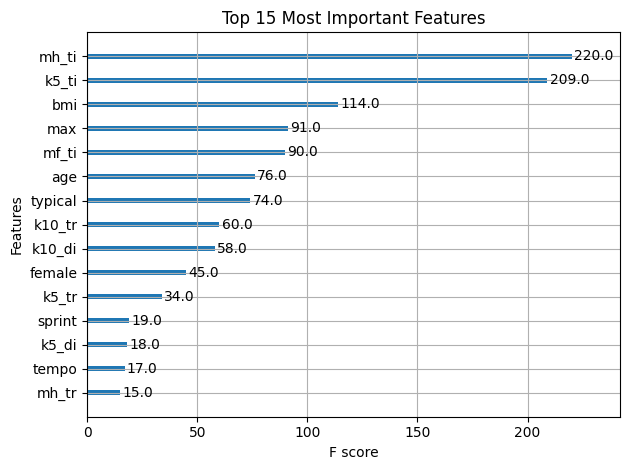

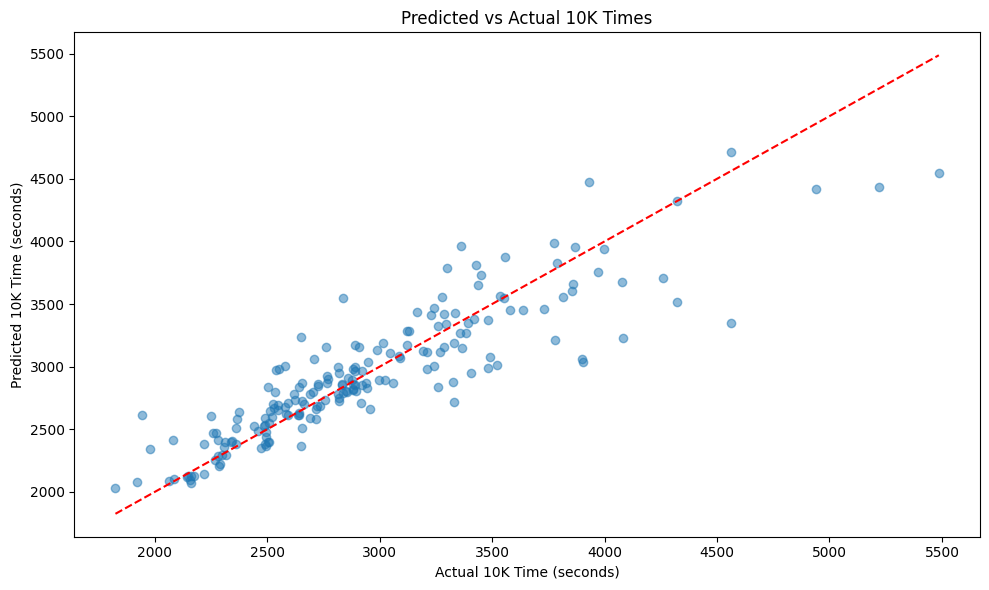

In [28]:
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, max_num_features=15)
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

# Create scatter plot with different colors for different race combinations
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual 10K Time (seconds)')
plt.ylabel('Predicted 10K Time (seconds)')
plt.title('Predicted vs Actual 10K Times')
plt.tight_layout()
plt.show()